Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sn
from sklearn.decomposition import PCA

Load preprocessed dataset

In [3]:
# Load the dataset
data = pd.read_csv('bank-additional.csv', delimiter=';')

# Replace "unknown" with NaN
data.replace('unknown', pd.NA, inplace=True)

# Convert yes to 1, no to 0 for the 'y' column
data['y'].replace({'yes': 1, 'no': 0}, inplace=True)

# Identify numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns

# Handle missing values for numeric columns (impute with the mean)
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Handle missing values for categorical columns (impute with the most frequent value)
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

# One-hot encode categorical features using pandas get_dummies
data = pd.get_dummies(data, columns=categorical_columns)

# Convert boolean values to integers (1 for True, 0 for False)
data = data.astype(int)

# Separate input features and prediction feature
X = data.drop(columns=['y'])
y = data['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric columns for normalization
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

Use GridSearch to automate the process of looking for the best parameters and use them for training and calculate the accuracy

In [4]:
# Define the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes': [(64,), (32,)],
    'activation': ['relu', 'logistic'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.001, 0.01],
    'max_iter': [100]
}

# Create MLPClassifier
mlp_model = MLPClassifier()

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model with the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Use the best model for further evaluation
best_model = grid_search.best_estimator_

# Evaluate the model
accuracy = best_model.score(X_test, y_test)
print('Test Accuracy:', accuracy)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/joan/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/joan/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/joan/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

Best Parameters:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (64,), 'max_iter': 100, 'solver': 'adam'}
Best Accuracy:  0.9116843702579664
Test Accuracy: 0.8907766990291263


/home/joan/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Compute and plot Confusion Matrices, ROC and Error Rate

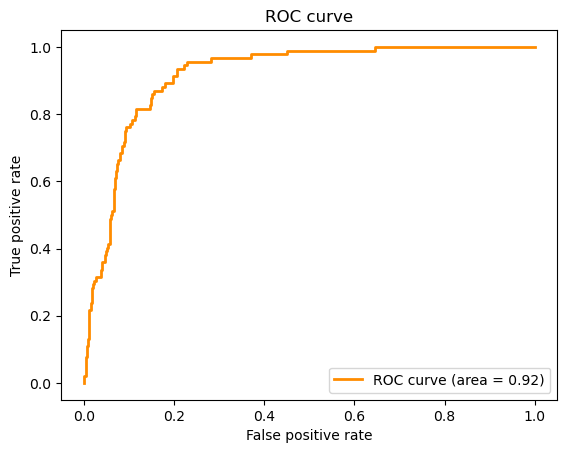

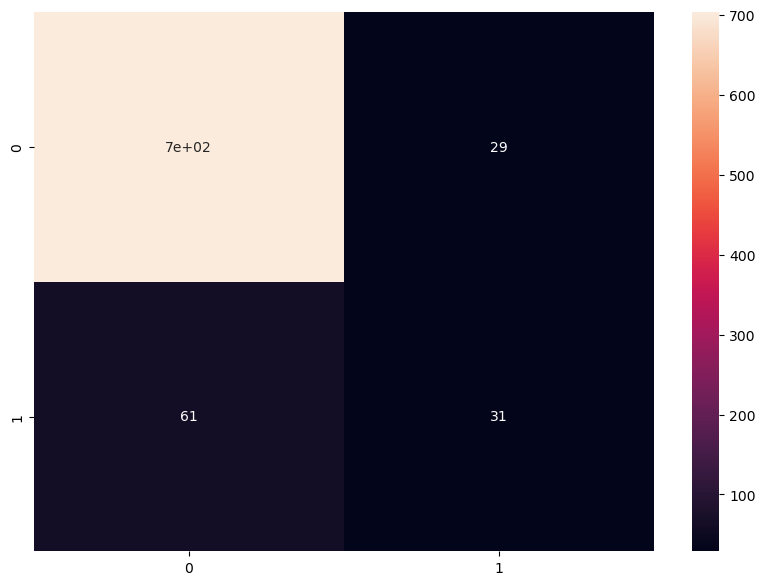

Error rate:  10.922330097087379


In [8]:
# Use the best model for prediction on the test set
y_pred = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Use the best model for prediction on the test set
y_pred = best_model.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.show()

# Compute classification error percentage
error_rate = 100 * (cm[0, 1] + cm[1, 0]) / (cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1])
print('Error rate: ', error_rate)



Visualization

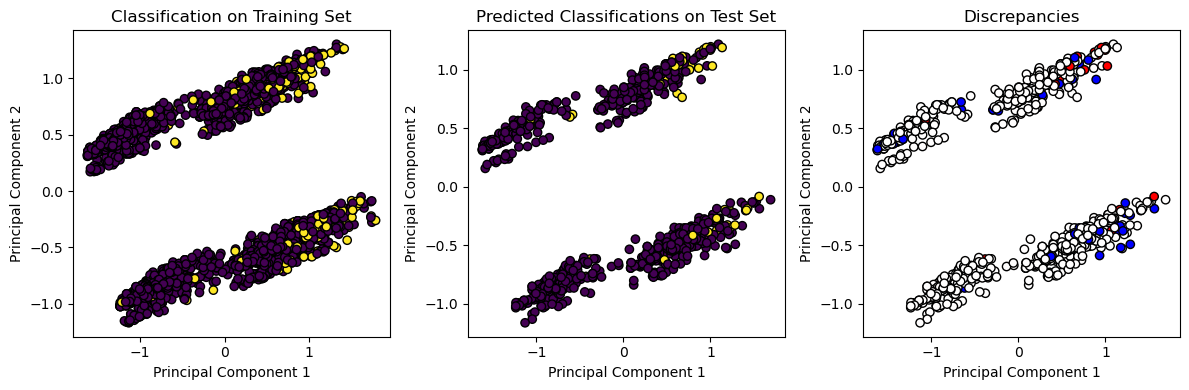

In [6]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot 1: Classification Dynamics on the Training Set
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.title('Classification on Training Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot 2: Predicted Classifications on the Test Set
X_test_pca = pca.transform(X_test)
test_pred_pca = pca.transform(X_test)

plt.subplot(1, 3, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='viridis', edgecolor='k')
plt.title('Predicted Classifications on Test Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot 3: Discrepancies between Predicted and True Classifications
discrepancies = y_pred - y_test.values
plt.subplot(1, 3, 3)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=discrepancies, cmap='bwr', edgecolor='k')
plt.title('Discrepancies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()
